<img src="images/nvidia_header.png" style="margin-left: -30px; width: 300px; float: left;">

# Physics NeMo External Aerodynamics DLI

## Notebook 3 – Using the DoMINO-Automotive-Aero NIM

In this notebook, we explore the practical application of the **DoMINO-Automotive-Aero Neural Inference Model (NIM)** for aerodynamic analysis of road vehicles. This pre-trained model represents a significant advancement in computational fluid dynamics (CFD) simulation, offering a rapid and efficient alternative to traditional RANS simulations.

The model has been trained on an extensive dataset of **1,500 steady-state RANS simulations** of road vehicles with varying geometries, operating at speeds from **20 m/s to 50 m/s**.

## Table of Contents

- [Overview](#overview)
- [Understanding the DoMINO-Automotive-Aero NIM Architecture](#understanding-the-domino-automotive-aero-nim-architecture)
- [Usability Guidelines](#usability-guidelines)
- [Fetching Input Data](#fetching-input-data)
- [Producing a Forecast with the DoMINO-Automotive-Aero NIM](#producing-a-forecast-with-the-domino-automotive-aero-nim)
- [Visualization and Validation](#visualization-and-validation)

## Overview

The objective of this NIM is to showcase the potential of foundation models in the design of roadside vehicles. It serves as a valuable starting point for:

- **ISV developers**
- **Aerodynamic engineers**
- **Designers**
- **Researchers**

These professionals can use the tool in the early stages of design evaluation. The model also offers capabilities for **retraining and fine-tuning** with custom datasets  to meet specific needs or scenarios.

## Understanding the DoMINO-Automotive-Aero NIM Architecture

### Scope
- Vehicle Classes:
    The DoMINO-Automotive-Aero model is designed to handle various vehicle types, including Sedans, SUVs, Pickups, Vans, Hatchbacks, and Sports Cars. In total, it encompasses around 40 different vehicle designs, each with 10 distinct geometric variations and tested at 4 different flow speeds. This variety allows the model to account for a wide range of vehicle shapes, sizes, and aerodynamic behaviors, providing users with versatile design and performance insights across different vehicle categories.

- Inflow Speeds:
    The model is capable of simulating airflow over the vehicle at a range of inflow speeds from 20 to 60 meters per second (approximately 45 to 135 mph). This range of speeds is representative of typical real-world driving conditions, allowing users to assess the vehicle's aerodynamic performance across different driving scenarios—from city traffic to highway speeds.

- Training Data:
    The training dataset used to build the model consists of around 1500 OpenFOAM simulations, which include a volume of 20 to 50 million elements each. These simulations were generated using Monte Carlo sampling techniques, which involve randomizing vehicle IDs, geometric variations, and inflow speeds to ensure a broad and representative set of training examples. This helps the model capture a wide range of real-world variations, improving its predictive power and accuracy. The data was also generated with steady-state Reynolds-Averaged Navier-Stokes (RANS) equations, the k-omega SST turbulence model, and a moving floor setup, with stationary wheels. The setup was validated using the canonical DrivAer model, ensuring its robustness and reliability.

- Simulation Setup:
    The model uses steady-state RANS equations with the k-omega SST turbulence model, a widely used approach for capturing turbulent flow characteristics around vehicles. The setup also includes a moving floor and stationary wheels, simulating real-world driving conditions. This validation was carried out using the DrivAer model, a standard benchmark for aerodynamic simulations, ensuring that the model accurately reflects realistic vehicle dynamics and performance.

- Optimization:
    The DoMINO-Automotive-Aero model is optimized to run efficiently on high-performance GPUs, specifically the H100, A100, and L40 models. It is designed to work on a single GPU, allowing users to conduct aerodynamic analyses without needing extensive computational resources. However, to ensure optimal performance, it is recommended that users have GPUs with at least 40 GB of memory to handle the computational demands of the model.


### Limitations/Issues:

- STL Input Constraints:
    The model currently imposes a limitation on the number of STL elements that can be processed, which ranges from 3 to 20 million elements, depending on the available GPU memory. This limitation is due to a known issue related to the Signed Distance Field computation using Warp technology, which will be resolved in the next release of the NIM. In the meantime, users are advised to decimate their STL files, reducing the number of elements to fit within the model's capacity. Decimation involves simplifying the geometry without compromising the overall shape or aerodynamic characteristics of the vehicle.

- Validation Confidence:
    The accuracy of the model's predictions is higher for certain vehicle classes, particularly Sedans and SUVs. These vehicle classes were more extensively represented in the training data, resulting in greater confidence when predicting aerodynamic performance for these types of vehicles. For other vehicle classes, such as Pickups or Vans, the model may have lower predictive confidence, as these were less frequently included in the training set. This is reflected in the benchmarking results, which provide users with a clearer understanding of where the model performs best.
- Retrained Checkpoint:
    One limitation of the current model is that it does not yet support the ability to ingest retrained checkpoints back into the NIM for further simulations. While users can fine-tune the model with their custom datasets, the retrained model cannot currently be integrated into the system for inference. This feature is expected in the next NIM release, but in the meantime, users can still evaluate and validate the performance of their retrained models using the utilities provided in the Domino example in the Modulus repository. This allows users to assess the impact of custom data and retraining on model performance outside the scope of the NIM system.


### Documentation and Licensing

For comprehensive documentation and deployment guides, visit the [NVIDIA AI Enterprise Documentation Hub](https://docs.nvidia.com/ai-enterprise/).

### Governing Terms:
The NIM container and model usage are governed by:
- [NVIDIA Software License Agreement](https://arc.net/l/quote/nhsxdxuw)
- [Product-Specific Terms for AI Products](https://arc.net/l/quote/ymuskinx)
- [NVIDIA Community Model License](https://arc.net/l/quote/lvlbclun)

**Note**: Users are responsible for ensuring compliance with all applicable laws and regulations when using NVIDIA AI Foundation Models.

In [1]:
# Standard library imports
import copy
import io
import os
import yaml
from pathlib import Path
from types import SimpleNamespace

# Third-party imports
import httpx
import requests
import numpy as np
import torch
import trimesh
import vtk
import matplotlib.pyplot as plt
import pyvista as pv
from tqdm import tqdm
from scipy.interpolate import griddata
from IPython.display import Image, display

# Torch utilities
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, DistributedSampler
from torch.nn.parallel import DistributedDataParallel

from physicsnemo.launch.utils import save_checkpoint
from physicsnemo.datapipes.cae.domino_datapipe import DoMINODataPipe
from physicsnemo.models.domino.model import DoMINO
from physicsnemo.utils.domino.utils import *

from utils import *

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/tritonserver/backends/dali/wheel/dali/nvidia/dali/types.py:433: SyntaxWarning: invalid escape sequence '\.'
  _cupy_array_type_regex = re.compile(".*cupy.*\..*ndarray.*")  # noqa: W605


## Fetching Input Data
The DoMINO-Automotive-Aero NIM takes an STL file as the input. The STL file should consist of a single solid. If your file consists of multiple solids, follow the instructions below to combine all into a single solid.
For downloading the STL files for the DrivearML dataset, please refer to this website https://huggingface.co/datasets/neashton/drivaerml.

This will download the STL file of the first sample in this dataset in the drivaerml_stls directory. Modify the loop in the provided code to download different samples if needed. The STL files in this dataset consist of multiple solids. Use the follwing script to convert those to a single solid:

In [ ]:
# Define the input and output directory and file path
input_file  = 'data/drivaer_data/run_1/body.stl'
output_dir = 'data/drivaer_data/drivaerml_single_solid_stls'
stl_file_path = os.path.join(output_dir, 'single_solid_body.stl')

os.makedirs(output_dir, exist_ok=True)

# Load and process the mesh
m = trimesh.load_mesh(input_file)
if isinstance(m, trimesh.Scene):
    m = trimesh.util.concatenate(list(m.geometry.values()))

# Print mesh information
print("\nMesh Information:")
print(f"Number of vertices: {len(m.vertices)}")
print(f"Number of faces: {len(m.faces)}")
print(f"Mesh volume: {m.volume:.2f} cubic units")
print(f"Mesh bounds: {m.bounds}")
print(f"Mesh is watertight: {m.is_watertight}")
print(f"Mesh is oriented: {m.is_winding_consistent}")

# Export the processed mesh
print("\nExporting processed mesh...")
m.export(stl_file_path)
print(f"Saved processed mesh to: {stl_file_path}")


# Verify the exported file
print("\nVerifying exported file...")
m_verify = trimesh.load_mesh(stl_file_path)
print(f"Verification - Number of vertices: {len(m_verify.vertices)}")
print(f"Verification - Number of faces: {len(m_verify.faces)}")


Mesh Information:
Number of vertices: 386162
Number of faces: 753234
Mesh volume: 6.85 cubic units
Mesh bounds: [[-0.765196 -1.01025  -0.319641]
 [ 3.93848   1.01025   1.19511 ]]
Mesh is watertight: False
Mesh is oriented: True

Exporting processed mesh...
Saved processed mesh to: data/drivaerml_stls/run_1/drivaerml_single_solid_stls/single_solid_body.stl

Verifying exported file...
Verification - Number of vertices: 376531
Verification - Number of faces: 753234


This will create the ```single_solid_body.stl``` file in the ```drivaerml_single_solid_stls``` directory.

## Producing a Forecast with the DoMINO-Automotive-Aero NIM

With the prepared STL file, we can now utilize the NIM API for aerodynamic analysis. The API accepts the STL file along with several key parameters that control the inference process and solution quality.

### Inference Parameters

The NIM API accepts several key parameters that control the inference process:

1. **stream_velocity** (float):
   - Unit: meters per second (m/s)
   - Range: 20-60 m/s
   - Purpose: Specifies the freestream velocity for the simulation
   - Impact: Directly affects Reynolds number and flow characteristics

2. **stencil_size** (integer):
   - Purpose: Controls local information propagation
   - Impact on Performance:
     - Larger values: Improved accuracy but increased computation time
     - Smaller values: Faster inference but potentially reduced accuracy
   - Recommended Range: 1-10

3. **point_cloud_size** (integer):
   - Purpose: Determines resolution of volume predictions
   - Impact on Results:
     - Higher values: More detailed flow field resolution
     - Lower values: Faster computation but coarser results
   - Recommended Range: 100,000-1,000,000 points

Modify these below to see the difference in accuracy, memory consumption and throughput.

In [ ]:
# Define the URL for the inference API
url = "http://localhost:8000/v1/infer"

# Define the parameters for the inference request
data = {
    "stream_velocity": "38.89",
    "stencil_size": "7",
    "point_cloud_size": "500000",
}

# Open the STL file and send it to the NIM
with open(stl_file_path, "rb") as stl_file:
    files = {"design_stl": (stl_file_path, stl_file)}
    r = httpx.post(url, files=files, data=data, timeout=120.0)

# Check if the request was successful
if r.status_code != 200:
    raise Exception(r.content)

# Load the response content into a NumPy array
with np.load(io.BytesIO(r.content)) as output_data:
    output_dict = {key: output_data[key] for key in output_data.keys()}  

# Print the keys of the output dictionary
print(output_dict.keys())

dict_keys(['sdf', 'coordinates', 'velocity', 'pressure', 'turbulent_kinetic_energy', 'turbulent_viscosity', 'bounding_box_dims', 'surface_coordinates', 'pressure_surface', 'wall_shear_stress', 'drag_force', 'lift_force'])


The NIM produces several output fields in the response dictionary:

### Volume Field Predictions:

  - ```coordinates```: 3D coordinates of points in the volume around the vehicle

  - ```velocity```: Velocity vector (u, v, w components) at each point in the volume

  - ```pressure```: Pressure values at each point in the volume

  - ```turbulent_kinetic_energy```: Turbulent kinetic energy at each volume point

  - ```turbulent_viscosity```: Turbulent viscosity at each volume point

  - ```sdf```: Signed distance field values at each point

### Surface Field Predictions:

  - ```surface_coordinates```: 3D coordinates of points on the vehicle surface

  - ```pressure_surface```: Pressure values on the vehicle surface

  - ```wall_shear_stress```: Wall shear stress values on the surface

Global Quantities:

  - ```drag_force```: Total aerodynamic drag force on the vehicle

  - ```lift_force```: Total aerodynamic lift force on the vehicle

  - ```bounding_box_dim```: Dimensions of the computational domain

Surface predictions are computed at each cell of the input mesh and can be visualized directly on the vehicle surface. Volume predictions are computed on a point cloud around the vehicle and can be used to visualize flow features in the surrounding air volume. The exact number of prediction points for volume quantities is controlled by the point_cloud_size parameter.

## Visualization and Validation
The final step is to perform some basic visualization of the results. The NIM provides both surface and volume field predictions that can be visualized using Python libraries like PyVista. Here’s an example script to visualize the volume and surface quantities:

Visualize the surface and volume field predictions for `single_solid-body.stl` and the ground truth from `aero_suv.vtp`.

/usr/local/lib/python3.12/dist-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


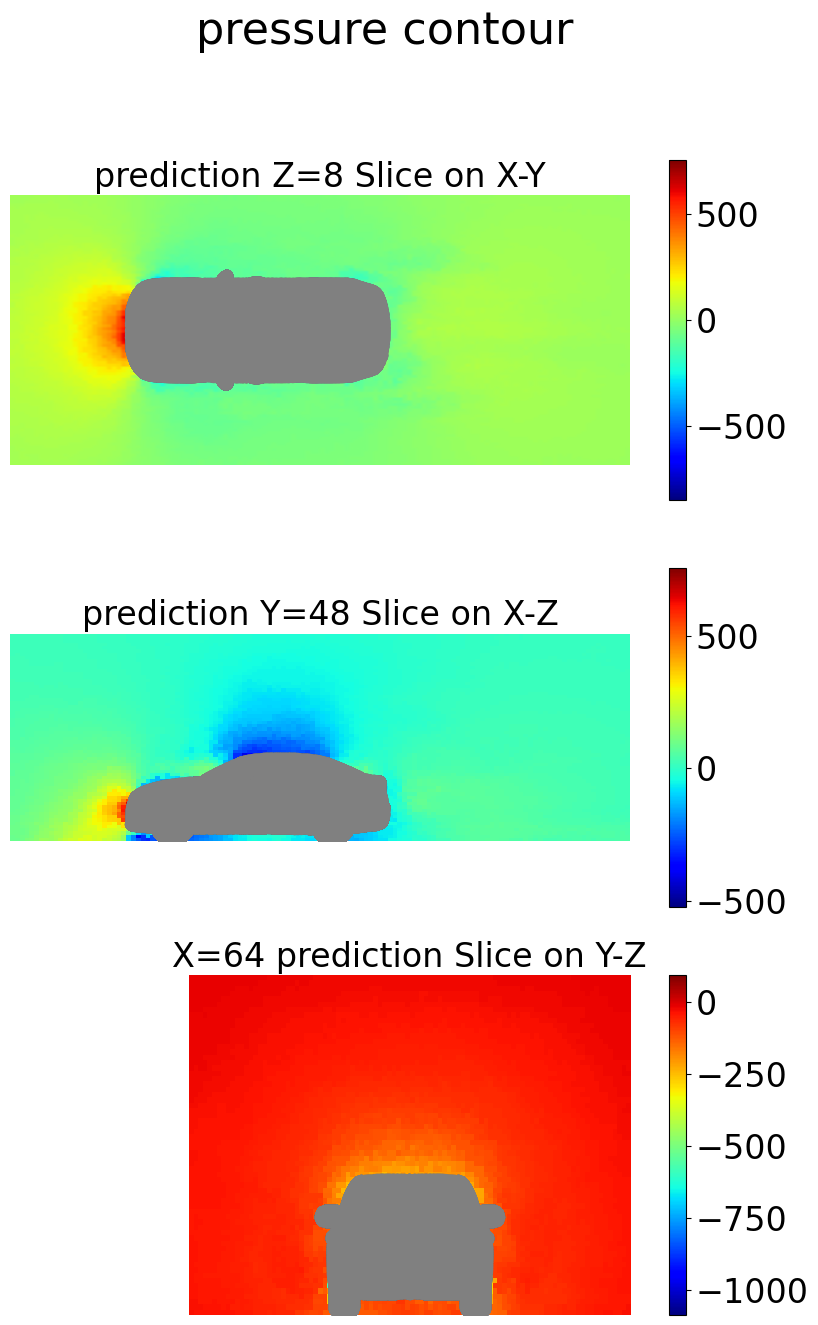

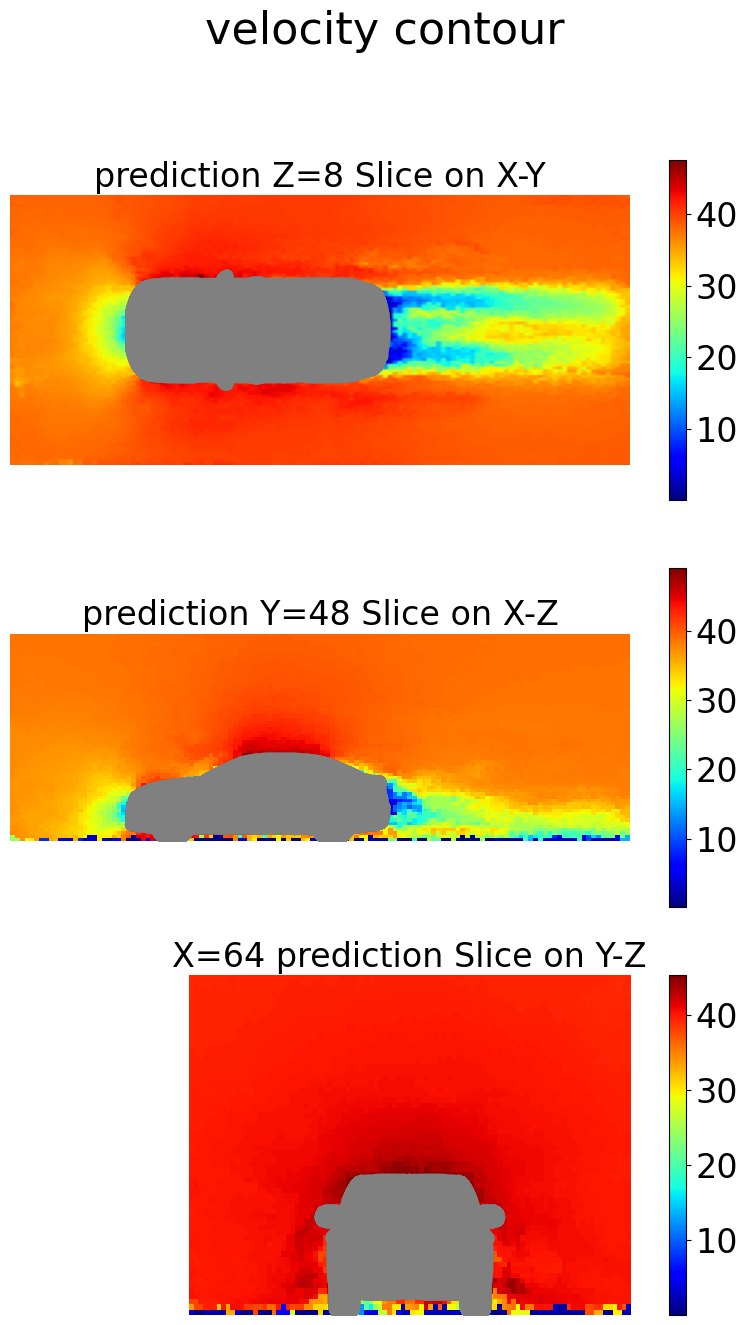

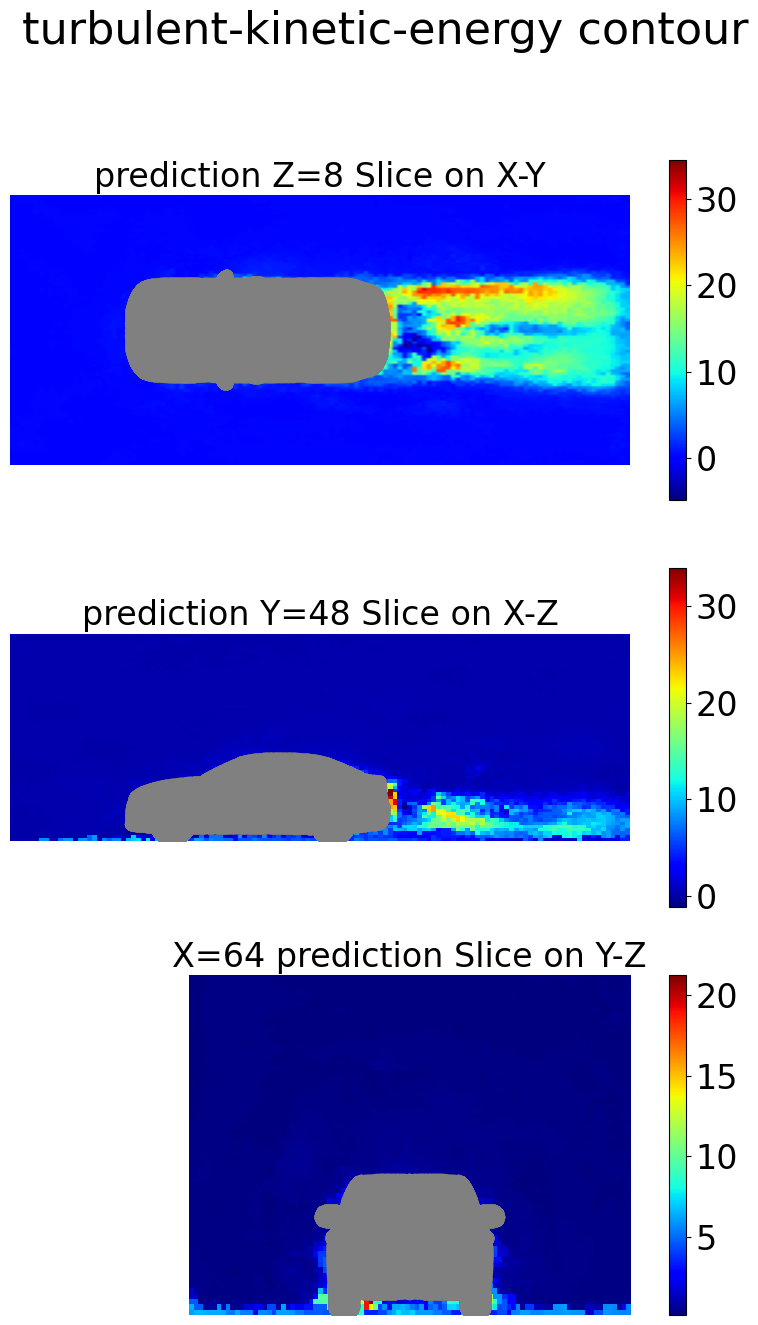

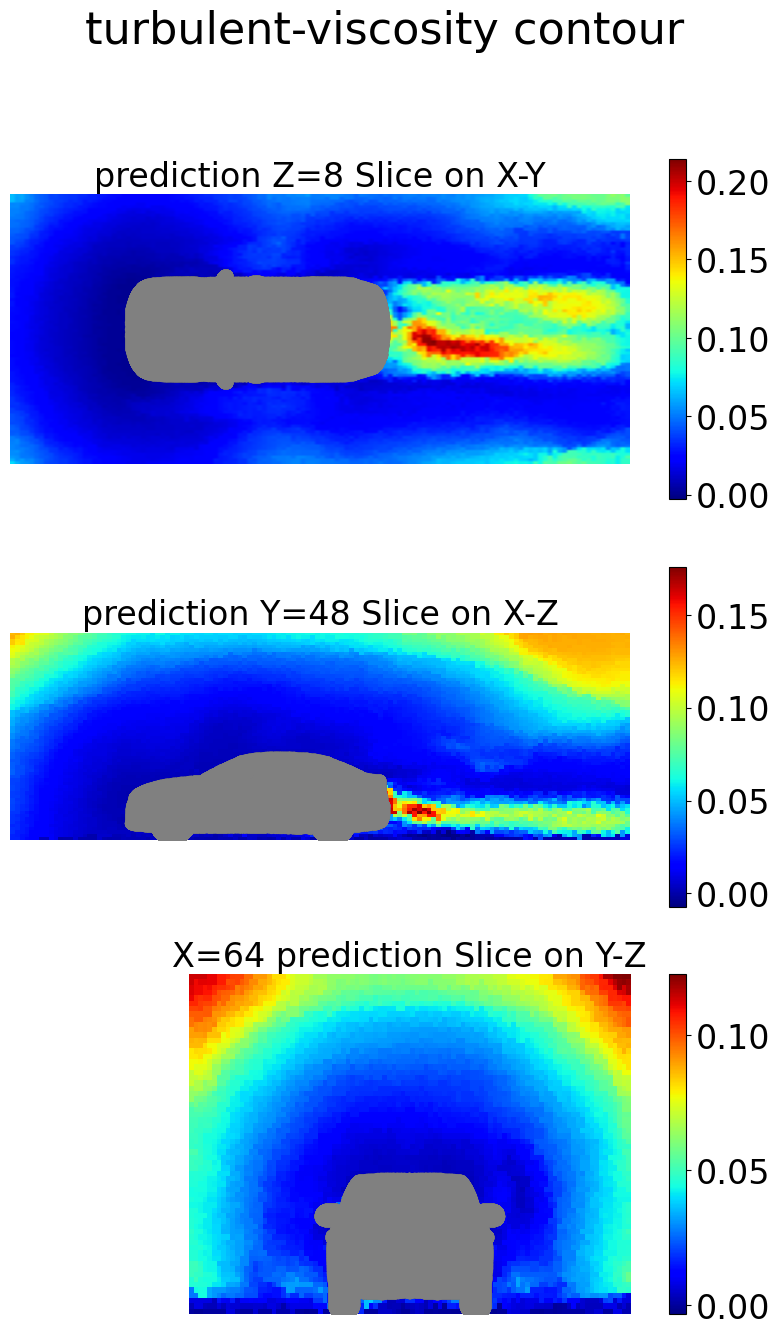

In [4]:
vtk.vtkObject.GlobalWarningDisplayOff()
os.environ["NO_AT_BRIDGE"] = "1"
os.environ['XDG_RUNTIME_DIR'] = '/tmp/runtime-root'

pv.start_xvfb()

# Read the mesh file
mesh = pv.read(stl_file_path)

truth_mesh = pv.read('data/drivaerml_stls/run_1/aero_suv.vtp')

# Rename fields to match the NIM output
truth_mesh.cell_data["pressure_surface"] = truth_mesh.cell_data["p"]

truth_output_dict = {
    # Surface data
    "pressure_surface": truth_mesh.cell_data["pressure_surface"].reshape(1, -1, 1),
    
    # Geometry information
    "bounding_box_dims": [
        truth_mesh.bounds[0:3],  # min coordinates
        truth_mesh.bounds[3:6]   # max coordinates
    ],
    "coordinates": [truth_mesh.points]  # Using mesh points as coordinates
}

grid_resolution = [128, 96, 64]

# First calculate global bounds for each field
vmin, vmax = output_dict["pressure_surface"].min(), output_dict["pressure_surface"].max()

# Then plot with consistent bounds
plot_contours(mesh, output_dict, grid_resolution, "prediction", vmin, vmax)
plot_contours(truth_mesh, truth_output_dict, grid_resolution, "truth", vmin, vmax)

The surface plots have been saved in the `base` directory - view them below to compare the predictions to the ground truth.

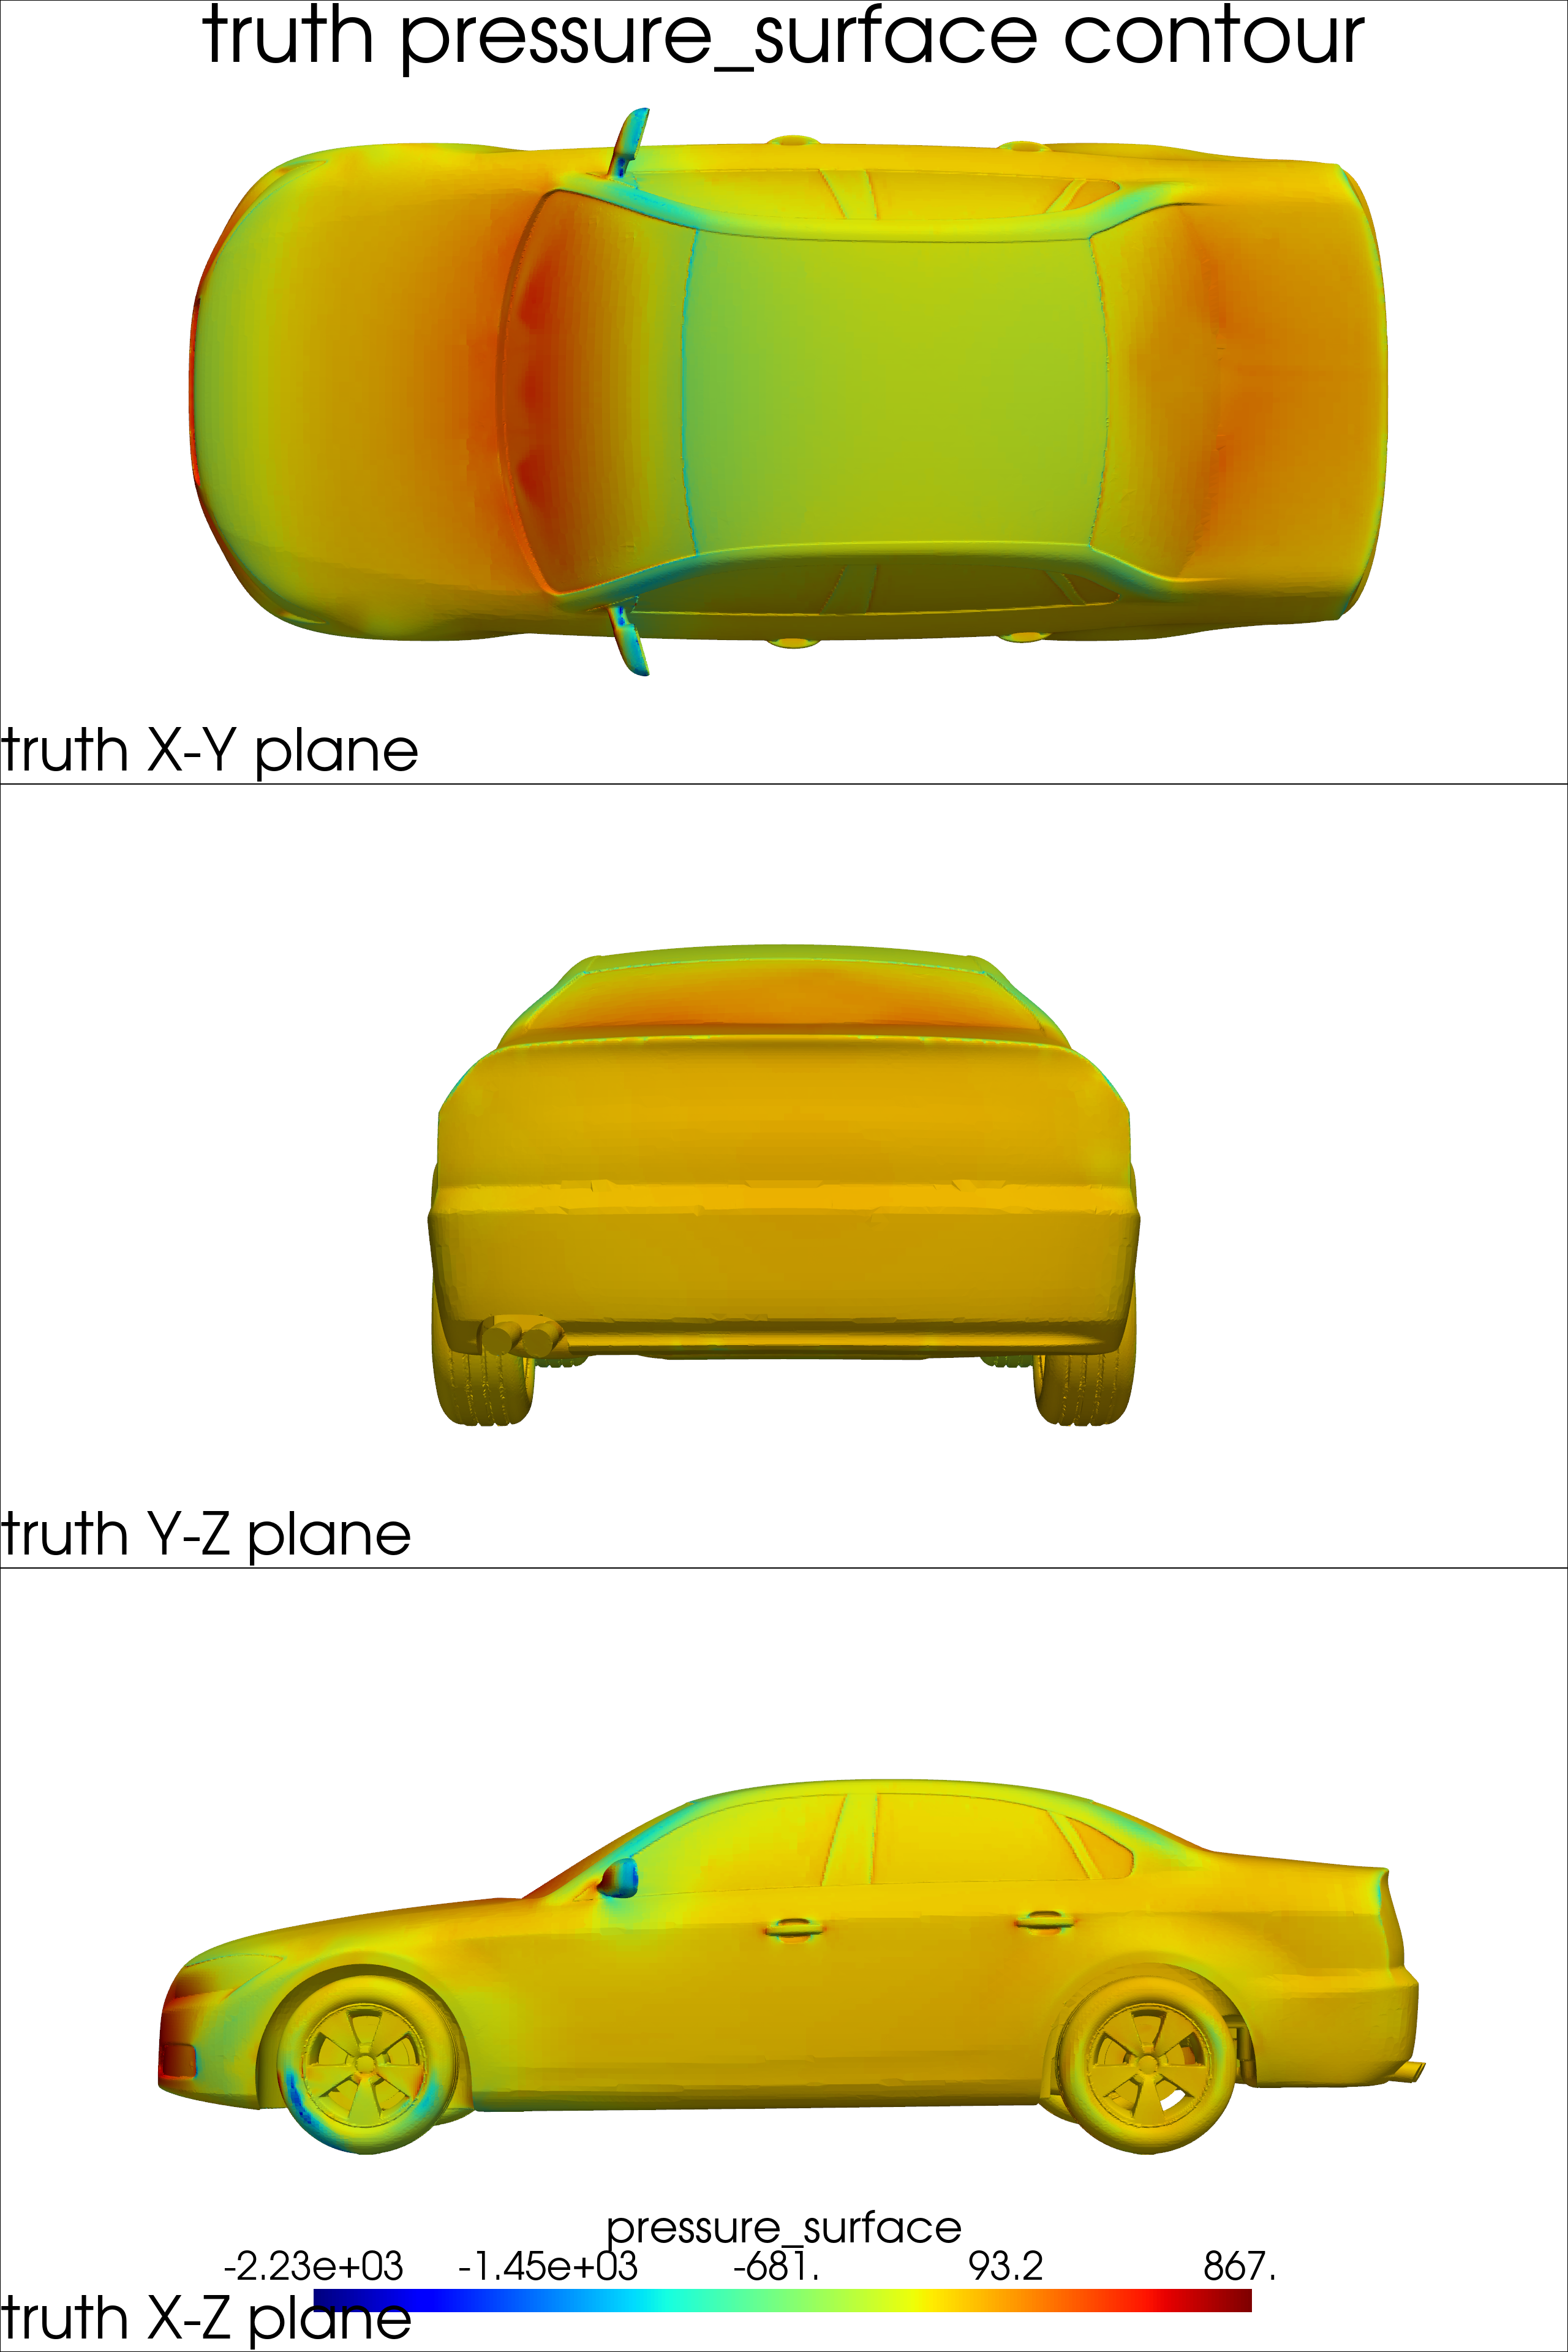

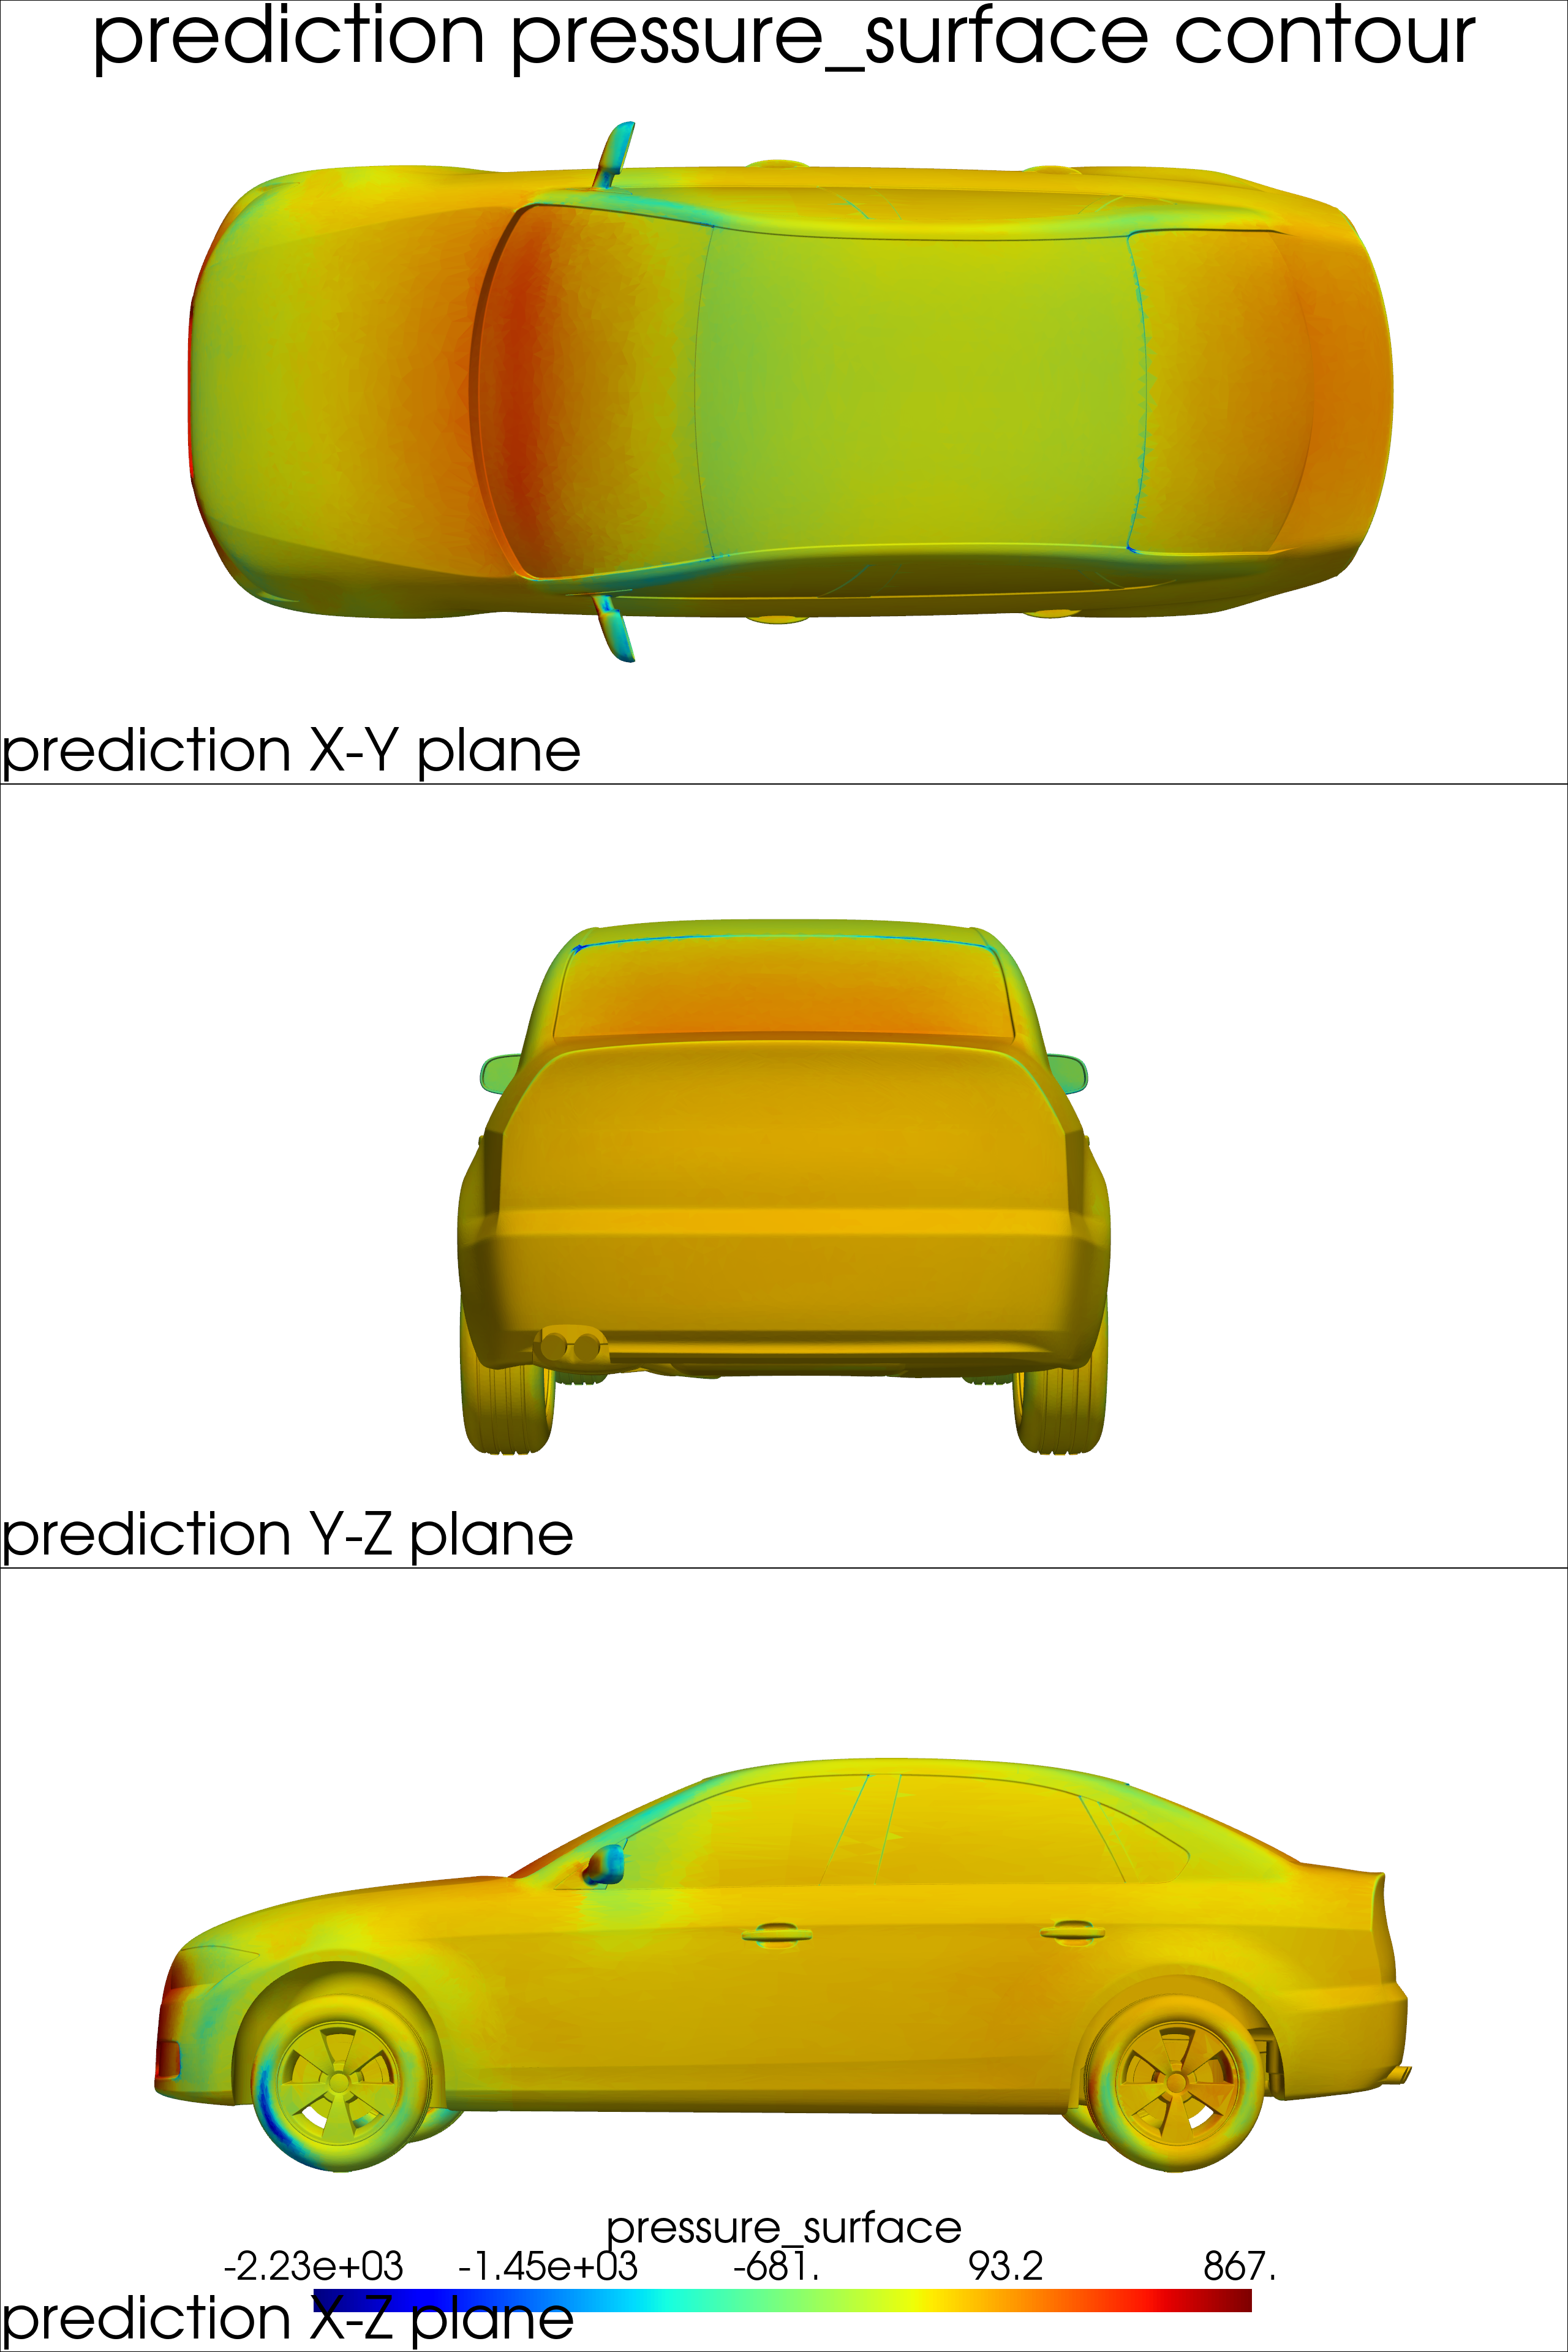

In [5]:
image_paths = [
    'truth_pressure_surface_contours.png',
    'prediction_pressure_surface_contours.png'
]

for imageName in image_paths:
    display(Image(filename=imageName))

<img src="images/nvidia_header.png" style="margin-left: -30px; width: 300px; float: left;">